First we will import the necessary packages.

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import math
#import os
#import io
#from six.moves import urllib
from google.colab import files
from scipy.optimize import minimize_scalar, fmin, minimize, fsolve, root
from mpl_toolkits import mplot3d

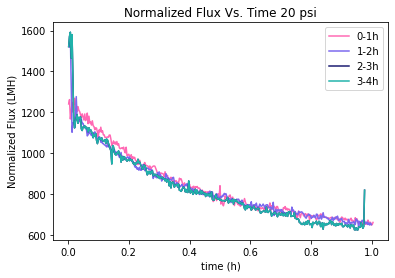

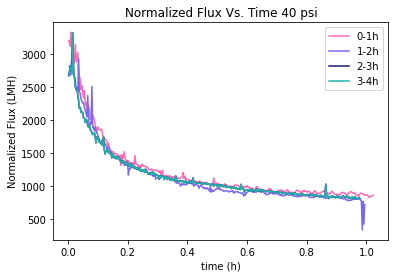

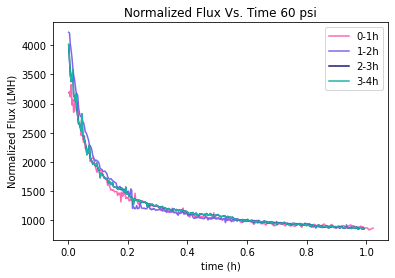

In [ ]:
# Now we will add the csv files from my github
# these are from the 200 nm ceramic membrane, ran at 20 psi
url001 = "https://raw.githubusercontent.com/KellieChong/E2Metrix-Membrane-Fouling-Model/main/200%20nm%20-%2020%20psi/01-20-2021-001.csv"  #First hour of the experiment
url002 = "https://raw.githubusercontent.com/KellieChong/E2Metrix-Membrane-Fouling-Model/main/200%20nm%20-%2020%20psi/01-20-2021-002.csv" #second hour
url003 = "https://raw.githubusercontent.com/KellieChong/E2Metrix-Membrane-Fouling-Model/main/200%20nm%20-%2020%20psi/01-20-2021-003.csv"# third hour
url004 = "https://raw.githubusercontent.com/KellieChong/E2Metrix-Membrane-Fouling-Model/main/200%20nm%20-%2020%20psi/01-20-2021-004.csv" #fourth hour

# Data frames are now to be loaded
df001 = pd.read_csv(url001)
df002 = pd.read_csv(url002)
df003 = pd.read_csv(url003)
df004 = pd.read_csv(url004)


#these are from the 200 nm ceramic membrane, now run at 40 psi 
url101 = "https://raw.githubusercontent.com/KellieChong/E2Metrix-Membrane-Fouling-Model/main/200%20nm%20-%2040%20psi/001.csv"
url102 = "https://raw.githubusercontent.com/KellieChong/E2Metrix-Membrane-Fouling-Model/main/200%20nm%20-%2040%20psi/002.csv"
url103 = "https://raw.githubusercontent.com/KellieChong/E2Metrix-Membrane-Fouling-Model/main/200%20nm%20-%2040%20psi/003.csv"
url104 = "https://raw.githubusercontent.com/KellieChong/E2Metrix-Membrane-Fouling-Model/main/200%20nm%20-%2040%20psi/004.csv"

df101 = pd.read_csv(url101)
df102 = pd.read_csv(url102)
df103 = pd.read_csv(url103)
df104 = pd.read_csv(url104)

#these are from the 200 nm ceramic membrane, now run at 60 psi 
url201 = "https://raw.githubusercontent.com/KellieChong/E2Metrix-Membrane-Fouling-Model/main/200%20nm%20-%2060%20psi/001.csv"
url202 = "https://raw.githubusercontent.com/KellieChong/E2Metrix-Membrane-Fouling-Model/main/200%20nm%20-%2060%20psi/002.csv"
url203 = "https://raw.githubusercontent.com/KellieChong/E2Metrix-Membrane-Fouling-Model/main/200%20nm%20-%2060%20psi/003.csv"
url204 = "https://raw.githubusercontent.com/KellieChong/E2Metrix-Membrane-Fouling-Model/main/200%20nm%20-%2060%20psi/004.csv"

df201 = pd.read_csv(url201)
df202 = pd.read_csv(url202)
df203 = pd.read_csv(url203)
df204 = pd.read_csv(url204)

# Plot our spliced raw data files for visualization
'''plt.plot(df001["time"], df001["J_v"], label = "0-1h")
plt.plot(df002["time"], df002["J_v"], label = "1-2h")
plt.plot(df003["time"], df003["J_v"], label = "2-3h")
plt.plot(df004["time"], df004["J_v"], label = "3-4h")
plt.title = ("Normalized Flux vs. Time")
plt.xlabel = ("time (h)")
plt.ylabel = ("Normalized Flux (LMH)")
plt.legend()
plt.show()'''

#plot using pandas
ax = df001.plot(x="time", y = "J_v", label = "0-1h", xlabel = "time (h)", ylabel = "Normalized Flux (LMH)", title = "Normalized Flux Vs. Time 20 psi", color = "hotpink")
df002.plot(x = "time", y = "J_v", label = "1-2h", xlabel = "time (h)", color = "mediumslateblue", ax=ax)
df003.plot(x = "time", y = "J_v", label = "2-3h", xlabel = "time (h)", color = "midnightblue", ax=ax)
df003.plot(x = "time", y = "J_v", label = "3-4h", xlabel = "time (h)", color = "lightseagreen", ax=ax)

ax2 = df101.plot(x = "time", y = "J_v", label = "0-1h", ylabel = "Normalized Flux (LMH)", title = "Normalized Flux Vs. Time 40 psi", color = "hotpink")
df102.plot(x = "time", y = "J_v", label = "1-2h", xlabel = "time (h)", color = "mediumslateblue", ax=ax2)
df103.plot(x = "time", y = "J_v", label = "2-3h", xlabel = "time (h)", color = "midnightblue", ax=ax2)
df103.plot(x = "time", y = "J_v", label = "3-4h", xlabel = "time (h)", color = "lightseagreen", ax=ax2)

ax3 = df101.plot(x = "time", y = "J_v", label = "0-1h", ylabel = "Normalized Flux (LMH)", title = "Normalized Flux Vs. Time 60 psi", color = "hotpink")
df202.plot(x = "time", y = "J_v", label = "1-2h", xlabel = "time (h)", color = "mediumslateblue", ax=ax3)
df203.plot(x = "time", y = "J_v", label = "2-3h", xlabel = "time (h)", color = "midnightblue", ax=ax3)
df203.plot(x = "time", y = "J_v", label = "3-4h", xlabel = "time (h)", color = "lightseagreen", ax=ax3)

In [ ]:
# Let's the user choose the test of interest
# you may need to update the value of test if it does not update automatically
test = widgets.Dropdown(options = [("0-1h", 0), ("1-2h", 1), ("2-3h", 2), ("3-4h", 3)], value = 0, description = "Choose your dataset of interest:", style = {'description_width': 'initial'})
pressure = widgets.Dropdown(options = [("20", 20), ("40", 40), ("60", 60)], value = 40, description = "Select your standard operating pressure:", style = {'description_width': 'initial'})
display(test, pressure)

Dropdown(description='Choose your dataset of interest:', options=(('0-1h', 0), ('1-2h', 1), ('2-3h', 2), ('3-4…

Dropdown(description='Select your standard operating pressure:', index=1, options=(('20', 20), ('40', 40), ('6…

In [ ]:
#We need to tell python where to find the correct data frames
if pressure.value == 20:
  df1, df2, df3, df4 = df001, df002, df003, df004
elif pressure.value == 40:
  df1, df2, df3, df4 = df101, df102, df103, df104
else:
  df1, df2, df3, df4 = df201, df202, df203, df204

# Now we'll create the functions and store them into arrays to later be compared to our raw data to see the mechanism of fouling
#7 possibilities exist: 1:Complete Pore Blocking, 2: Intermediate Blocking, 3: Pore constriction, and 4: Cake filtration, +3 combined models
Jo = df1["J_v"][0] #Define this now for simplicity to be used in future equations
database = [[Jo, df2["J_v"][0], df3["J_v"][0], df4["J_v"][0]], #the Jo values
            [df1["J_v"], df2["J_v"], df3["J_v"], df4["J_v"]], # J_v values
            [df1["time"], df2["time"], df3["time"], df4["time"]]] # time intervals
mechanism = {
    "[0]": "Complete Pore Blocking",
    "[1]": "Intermediate Blocking",
    "[2]": "Pore Constriction",
    "[3]": "Cake Filtration",
    4: "Complete & Cake Combined Model",
    5: "Intermediate & Cake Combined Model",
    6: "Pore Constriction & Cake Combined Model"
}

Y = database[1][test.value].to_numpy()/database[0][test.value]
J_final = database[1][test.value].to_numpy()[-1]
t = database[2][test.value]

**Data Visualization:**

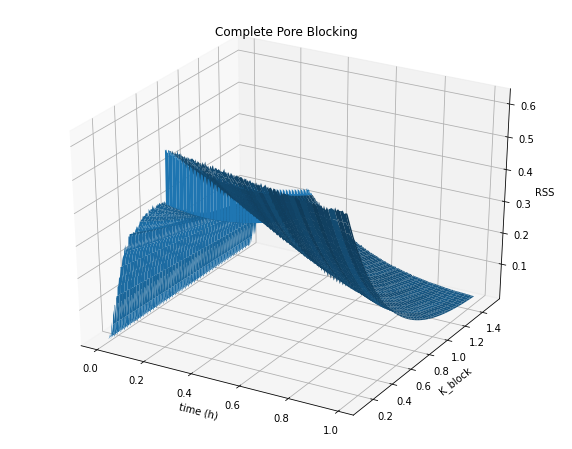

Complete pore blocking min RSS:  7.713907616976496e-08
Intermediate Blocking min RSS:  0.06355483368750367
Pore Constriction min RSS:  0.0040392168850462516
Cake Filtration min RSS:  0.0040392168850462516


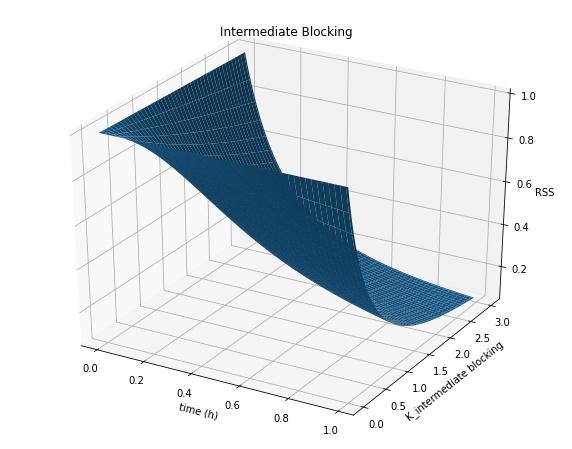

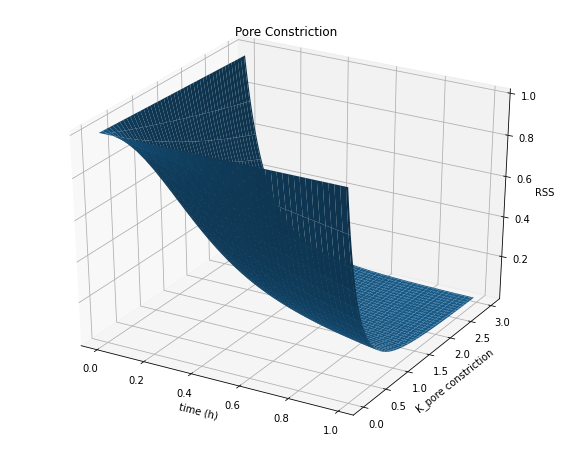

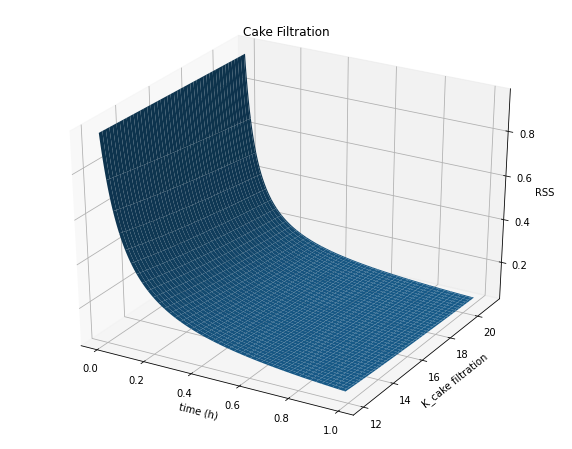

In [ ]:
#@title
Y = database[1][test.value].to_numpy()/database[0][test.value]
t = database[2][test.value]
K_block = np.linspace(0.1, 1.5, len(t))
K_inter = np.linspace(0, 3, len(t))
K_cake = np.linspace(12, 21, len(t))

# returns a 2D coordinate matrix from coordinate vectors of 1D
x, y = np.meshgrid(t, K_block)
x2, y2 = np.meshgrid(t, K_inter)
x4, y4 = np.meshgrid(t, K_cake)

# define all the functions for RSS of the mechanisms
z1 = np.square(Y - np.exp(-x*y))
z2 = np.square(np.power((1 + x2 * y2),-1))
z3 = np.square(np.power((1 + x2 * y2),-2))
z4 = np.square(np.power((1 + x4 * y4),-0.5))

# finds minimum RSS for a single time point if you wish, add this parameter to your plot if you want to see it
zmin = np.min(z1)
mask = np.array(1) == zmin
color = np.where(mask,'red', 'blue')

# complete pore blocking
fig1 = plt.figure(figsize =(10, 8))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot_surface(x, y, z1)
ax1.set_xlabel("time (h)")
ax1.set_ylabel("K_block")
ax1.set_zlabel("RSS")
ax1.set_title("Complete Pore Blocking")
plt.show()
print("Complete pore blocking min RSS: ", np.min(z1))

#Intermediate Blocking
fig2 = plt.figure(figsize =(10, 8))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot_surface(x2, y2, z2)
ax2.set_title("Intermediate Blocking")
ax2.set_xlabel("time (h)")
ax2.set_ylabel("K_intermediate blocking")
ax2.set_zlabel("RSS")
print("Intermediate Blocking min RSS: ", np.min(z2))

#Pore Constriction
fig3 = plt.figure(figsize =(10, 8))
ax3 = fig3.add_subplot(111, projection='3d')
ax3.plot_surface(x2, y2, z3)
ax3.set_title("Pore Constriction")
ax3.set_xlabel("time (h)")
ax3.set_ylabel("K_pore constriction")
ax3.set_zlabel("RSS")
print("Pore Constriction min RSS: ", np.min(z3))

#Cake Filtration
fig4 = plt.figure(figsize =(10, 8))
ax4 = fig4.add_subplot(111, projection='3d')
ax4.plot_surface(x4, y4, z4)
ax4.set_title("Cake Filtration")
ax4.set_xlabel("time (h)")
ax4.set_ylabel("K_cake filtration")
ax4.set_zlabel("RSS")
print("Cake Filtration min RSS: ", np.min(z3))

#plot all now
#plt.show()

**Integrate the graphs over the entire time domain, and K_i -> K_i+1 now:**

In [ ]:
#@title
#Now that we can visually see if we are on the right track or not, we want to take slice integrals of all t values for a certain K_i -> K_i+1

def Z1(x, y, Y):
  return np.square(Y - np.exp(-x*y))

def Z2(x, y, Y):
  return np.square(Y - np.power((1+x*y), -1))


def Z3(x, y, Y):
  return np.square(Y - np.power((1+x*y), -2))


def Z4(x, y, Y):
  return np.square(Y - np.power((1+x*y), -0.5))

i = 0
j = 0
RSS = np.zeros((len(t), 4))
#the j index is for the K vector
#the i index is to iterate through the entire time domain

for j in range(len(t)):
  #reinitialize the value of the columns
  col1 = 0
  col2 = 0
  col3 = 0
  col4 = 0 
  for i in range(len(t)):
    col1 += Z1(t[i], K_block[j], Y[i])
    col2 += Z2(t[i], K_inter[j], Y[i])
    col3 += Z3(t[i], K_inter[j], Y[i])
    col4 += Z4(t[i], K_cake[j], Y[i])
  
  RSS[j] = [col1, col2, col3, col4]
  j += 1
  
#print(RSS)
np.savetxt("RSS.csv", RSS, delimiter=",")
#uncomment to make sure searching algorithim is working properly and see the entire array
#a = open("RSS.csv", 'r')
#print(a.read())
print("Some Model Metrics: ")
print("maximum RSS: " , np.amax(RSS))
print("maximum RSS index: ", np.where(RSS == np.amax(RSS)))
print("minimum RSS: ", np.amin(RSS))
print("minimum RSS index: ", np.where(RSS == np.amin(RSS)))

#print(RSS)

Some Model Metrics: 
maximum RSS:  209.31325254791926
maximum RSS index:  (array([0, 0]), array([1, 2]))
minimum RSS:  2.4222897849643115
minimum RSS index:  (array([355]), array([2]))


Compute the Optimal K value and proposed mechanism of fouling

In [ ]:
#@title
index = (np.where(RSS == np.amin(RSS)))
if index[1] == 0:
  K = K_block
elif index[1] == 3:
  K = K_cake
else:
  K = K_inter

method = mechanism[str(index[1])]
K_optimal = float(K[(index[0])])

print("The proposed mechanism of fouling is: ", method)
print("The optimal K value is: ", K_optimal) #K_optimal


The proposed mechanism of fouling is:  Pore Constriction
The optimal K value is:  3.0


**Plotting Our Model versus the Raw Data now**

The total RSS of this model is:  2.422289784964312


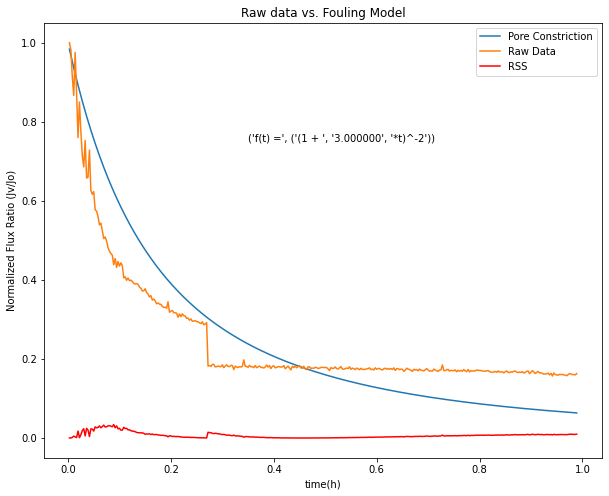

In [ ]:
#@title
if index[1] == 0:
  y_pred = np.exp(-K_optimal * t)
  eqn = "exp(-","%.6f" % K_optimal,"*t)"
elif index[1] == 1:
  y_pred = np.power((1+(K_optimal*t)), -1)
  eqn = '(1 + ','%.6f' % K_optimal,"*t)^-1"
elif index[1] == 2:
  y_pred = np.power((1+(K_optimal*t)), -2)
  eqn = "(1 + ","%.6f" % K_optimal,"*t)^-2"
else:
  y_pred = np.power((1+(K_optimal*t)), -0.5)
  eqn = "(1 + ","%.6f" % K_optimal,"*t)^-0.5"

RSS_2D_plot = np.square((Y-y_pred))
print("The total RSS of this model is: ", np.sum(RSS_2D_plot))
fig = plt.figure(figsize =(10, 8))
ax = fig.add_subplot()
ax.set_title("Raw data vs. Fouling Model")
ax.set_ylabel("Normalized Flux Ratio (Jv/Jo)")
ax.set_xlabel("time(h)")
ax.plot(t, y_pred, label = method)
plt.plot(t, Y, label = 'Raw Data')
plt.plot(t, RSS_2D_plot, label = 'RSS', color = 'r')
plt.title = "Fouling Model vs. Raw Data"
plt.legend(loc = "best")
plt.text(0.35, .75, ('f(t) =', eqn))
plt.show()


# Solve wtih Scipy optimizers

In [ ]:
#complete blocking
def Z1(y):
  return np.exp(-t*y)
#Intermediate blocking
def Z2(y):
  return np.power((1+t*y), -1)
#Pore constriction
def Z3(y):
  return np.power((1+t*y), -2)
#Cake filtration
def Z4(y):
  return np.power((1+t*y), -0.5)
#Cake and complete blocking combined model, K1 corresponds to complete pore blocking, 
def Z5(K1, K2, K3):
  return np.exp(-K1*t) + np.sqrt((1+K3)**-1 * (1+K2*t*(1+K3)**-2)) * (1-np.exp(-K1*t))

#the RSS functions to be used in the optimzier
def R1(y):
    return np.sum(np.square(Y - np.exp(-t*y)))

def R2(y):
  return np.sum(np.square(Y - np.power((1+t*y), -1)))


def R3(y):
  return np.sum(np.square(Y - np.power((1+t*y), -2)))


def R4(y):
  return np.sum(np.square(Y - np.power((1+t*y), -0.5)))
#combined: complete pore blocking and cake filtration
def R5(K):
  K1, K2, K3 = K
  rhs = np.exp(-K1*t) + np.sqrt((1+K3)**-1 * (1+K2*t*(1+K3)**-2)) * (1-np.exp(-K1*t))
  U = np.square(Y - rhs)
  return np.sum(U)
#combined: intermediate blocking and cake filtration
def R6(K):
  K1, K2, K3 = K
  rhs = np.power((1+t*K1), -1) + np.sqrt((1+K3)**-1 * (1+K2*t*(1+K3)**-2)) * (1 - np.power((1+t*K1), -1))
  U = np.square(Y - rhs)
  return np.sum(U)
#combined: pore constriction  and cake filtration
def R7(K):
  K1, K2, K3 = K
  rhs = np.power((1+t*K1), -2) + np.sqrt((1+K3)**-1 * (1+K2*t*(1+K3)**-2)) * (1 - np.power((1+t*K1), -2))
  U = np.square(Y - rhs)
  return np.sum(U)

class Mechanism:
  #shared by all values in the class
  Y = database[1][test.value].to_numpy()/database[0][test.value]
  t = database[2][test.value]
  def __init__(self, eqn):
    self.eqn = eqn
  
  def RSS_eq(self):
    return np.sum(np.square(eqn))

  def opt_res(self):
    f = RSS_eq(eqn)
    if eqn == Z5 or eqn == Z6 or eqn == z7:
      self.res = minimize(f, [5, 5, 5])
    else:
      self.res = minimize_scalar(f)
    return res 

Y = Mechanism.Y
t = Mechanism.t


comp, inter, pore, cake = minimize_scalar(R1, method='brent'),  minimize_scalar(R2), minimize_scalar(R3), minimize_scalar(R4)
#print(comp.fun, inter.fun, pore.fun, cake.fun)
#print(comp, "\n\n", inter, "\n\n", pore, "\n\n", cake)
combined_cc = minimize(R5, [5, 5, 5], method="BFGS")
combined_ic = minimize(R6, [5, 5, 5], method="BFGS")
combined_pc = minimize(R7, [5, 5, 5], method="BFGS")

K1, K2, K3 = combined_cc.x
k1, k2, k3 = combined_ic.x
K_1, K_2, K_3 = combined_pc.x
#print(K1, K2, K3)

RSS = [comp.fun, inter.fun, pore.fun, cake.fun, combined_cc.fun, combined_ic.fun, combined_pc.fun]
idx = np.argsort(RSS)[:]
text = "Lowest RSS: " + str(mechanism[idx[0]]) + " - " + str(round(np.min(RSS), 6))
#print(idx)
#Z1 = "np.exp(-t*y)"
#instances of the class
complete_block = Mechanism(Z1)
inter_block = Mechanism(Z2)
pore_constr = Mechanism(Z3)
cake_fil = Mechanism(Z4)
combined_mod = Mechanism(Z5)

#hi = complete_block.RSS_eq
#print(hi)
#print(complete_block.opt_res(hi))

def plot_all():
  fig = plt.figure(figsize=(10, 8))
  ax = fig.add_subplot()
  plt.plot(t, Y, label = "Experimental Value")
  ax.set_title("Blocking Mechanism Models vs. Experimental Values")
  ax.set_xlabel("Time (h)")
  ax.set_ylabel("Jv/Jo")
  plt.plot(t, complete_block.eqn(comp.x), label = "Complete Pore Blocking") #np.exp(-comp.x * t)
  plt.plot(t, np.power((1+(inter.x*t)), -1), label = "Intermediate Blocking")
  plt.plot(t, np.power((1+(pore.x*t)), -2), label = "Pore Constriction")
  plt.plot(t, np.power((1+(cake.x*t)), -0.5), label = "Cake Filtration")
  plt.plot(t, np.exp(-K1*t) + np.sqrt((1+K3)**-1 * (1+K2*t*(1+K3)**-2)) * (1-np.exp(-K1*t)), label = "Complete and Cake Combined Method")
  plt.plot(t, np.power((1+t*k1), -1) + np.sqrt((1+k3)**-1 * (1+k2*t*(1+k3)**-2)) * (1 - np.power((1+t*k1), -1)), label = "Intermediate and Cake Combined Method")
  plt.plot(t, np.power((1+t*K_1), -2) + np.sqrt((1+K_3)**-1 * (1+K_2*t*(1+K_3)**-2)) * (1 - np.power((1+t*K_1), -2)), label = "Pore Constriction and Cake Combined Method")
  
  plt.legend(loc='best')
  plt.text(0.35, 0.65, text, bbox=dict(facecolor='orange', alpha=0.5), FontSize=10)
  plt.savefig("200 nm TiO2 - 60 psi.png")
  #files.download("200 nm TiO2 - 60 psi.png") 
  return

print(RSS)


[0.7087932846774256, 0.2306594752587104, 0.41900426534402946, 0.07867012628477012, 0.04486879165204581, 0.05685629586435628, 0.04980797156581181]
119.17418723275617


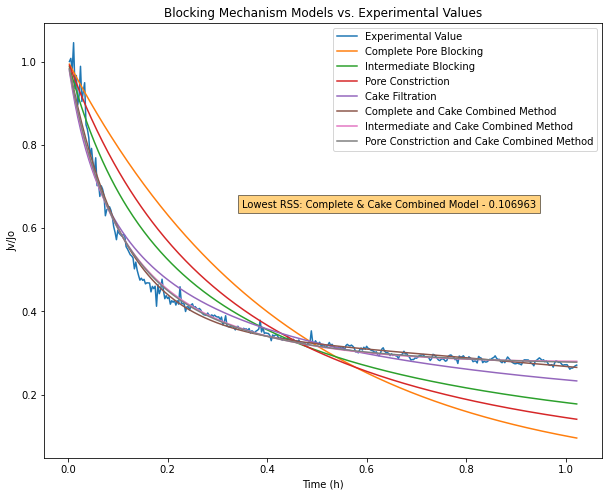

In [ ]:
plot_all()

In [ ]:
#Save csv data files of the plotted fouling mechanisms curves now
headers = ["Time (h)", "Complete Blocking", "Intermediate Blocking", "Pore Constriction", "Cake Filtration", "Combined Model"]
data = np.reshape([t, Z1(comp.x), Z2(inter.x), Z3(pore.x), Z4(cake.x), Z5(K1, K2, K3)], (len(t), 6))
datafile = pd.DataFrame(data = data, columns=headers)

datafile.to_csv("40 psi model.csv", index=False)
#files.download("40 psi model.csv") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Extract other parameters from the fitted model now

We will now use our fitted contants to determine the following for each of the tested pressures:

1. Cake resistance (Rc)
2. Cake thickness (dc)
3. Cake particle size (rp)

In [ ]:
#Use this dictionary to map pressure values to index values for use in indexing T
P = {20: 0, 40: 1, 60: 2} # returns index of pressure (20 psi: 0, 40 psi: 1, 60 psi: 2)
# Define the membrane and feed constants first:
#dP = [1.08538, 1.63462, 1.983073] #3-dimensional row vector with dP avg  of the first hour of operation for each pressure
phi_o = 0.002 #Particle volume fraction
ro = 0.0012 #membrane channel inner radius
Rm = [2.80519*np.power(10,11), 1.69052*np.power(10,12), 7.51472*np.power(10,12)] # Rm for 200 nm, 50 kDa, and 1 kDa membranes respectively
phi_max = 0.58 #volume fraaction of maximally packed particles in cake layer
T = [273.15 + 21.04, 21.187 + 273.15, 20.054 + 273.15]

#Define a lambda function for visocisty for simplicity
viscosity = lambda T: np.exp(-52.843 + 3703.6/T + 5.866 *np.log(T) - 5.879*10**(-29) * T**10)


def eq12(Kc, Rm, pressure, mu):
  RcPrime = Kc * Rm**2 * mu / (2 * pressure * phi_o)
  #print(RcPrime)
  return RcPrime

def eq34(x, Kc, Jo, Rm, pressure, RcPrime, mu):
  # set up our system of non-linear equations, we need to solve for dc and Rc
  eq = [RcPrime * ro * np.log(ro/(ro-x[0])) - x[1], #x[0] is dc and x[1] is  Rc
        J_final - Jo * Rm /(Rm + x[1])]  #pressure/(mu*(Rm + x[1])) - Jo * Rm /(Rm + x[1])]
  return eq

eq5 = lambda phi_max, RcPrime: np.sqrt(37.5 * phi_max**2/((1-phi_max)**3*RcPrime))

def get_sols(pressure, Rm, Jo, Kc, P, T):
  
  mu = viscosity(T)
  #print(mu)
  RcPrime = eq12(Kc, Rm, pressure, mu)
  #dc, Rc = fsolve(eq34, [0, 0], args=(Kc, Jo, Rm, pressure, RcPrime, mu)) #doesn't work as well as optimize.root for some reason?
  sol = root(eq34, [0.001, 1000], args=(Kc, Jo, Rm, pressure, RcPrime, mu), method = 'hybr', tol = 1e-7)
  #Rc = Jo * Rm / J_final - Rm
  #dc = - np.inverse(np.exp(Rc/(RcPrime * ro))/ro) + ro
  #print(np.log(ro/(ro-sol.x[0])))
  rp = eq5(phi_max, RcPrime)
  return sol.x, rp

sol, rp = get_sols(pressure.value, Rm[0], Jo, abs(K2), P[pressure.value], T[P[pressure.value]])
print("Cake thickness (m): ", sol[0],  "\nCake Resistance: ", sol[1] , "\nCake radius (m): ", rp)

Cake thickness (m):  0.00040734526163307863 
Cake Resistance:  5.817548486351917e+19 
Cake radius (m):  3.8163800494285255e-11


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log
